<a href="https://colab.research.google.com/github/sharon-kurant/VCE_Remission_Classification/blob/main/stills_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [12]:
import os
import pandas as pd
import numpy as np
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import tensorflow_hub as hub
import pathlib
import cv2
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

In [13]:
STILLS_PATH = "/content/drive/MyDrive/remission/stills/"
DATASETS_PATH = "/content/drive/MyDrive/remission/stills/normal_dataset/"
SAVE_MODEL_PATH = "/content/drive/MyDrive/remission/stills/models"

In [14]:
arguments = {
             "dataset": DATASETS_PATH,
             "save_model_path": SAVE_MODEL_PATH + os.sep + 'finetuned_hybrid_data_no_aug', #None will not save the model
             "training_layers": 0, # Last layers to train in Resnet, -1 is to freeze all
             "network": 'resnet', # efficient, mobile...
             "epochs": 15,
             "batch_size": 16,
             "image_size": (500,500),
             "test": True,
             "test_path": ''
            }

In [16]:
dataset = arguments["dataset"]
save_model_path = arguments["save_model_path"]
training_layers = arguments["training_layers"]
network = arguments["network"]
epochs = arguments["epochs"]
batch_size = arguments["batch_size"]
image_size = arguments["image_size"]
test = arguments["test"]
test_path = arguments['test_path']

In [17]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  dataset,
  validation_split=0.3,
  subset="training",
  seed=123,
  shuffle=True,
  labels = "inferred",
  image_size= image_size,
  batch_size = batch_size,
  crop_to_aspect_ratio = True)

Found 28119 files belonging to 2 classes.
Using 19684 files for training.


In [6]:
train_ds.class_names

['0', '1']

In [18]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  dataset,
  validation_split=0.3,
  subset="validation",
  seed=123,
  shuffle=True,
  labels = "inferred",
  image_size=image_size,
  batch_size=batch_size,
  crop_to_aspect_ratio = True)

Found 28119 files belonging to 2 classes.
Using 8435 files for validation.


In [10]:
# labels = np.concatenate([y for x, y in val_ds], axis=0)
# d = {key:[] for key in labels}
# d

In [21]:
val_ds.cardinality().numpy()

264

In [19]:
test_ds = val_ds.take(val_ds.cardinality().numpy() / 2 )
val_ds = val_ds.skip(val_ds.cardinality().numpy() / 2 )

In [20]:
model = Sequential()

pretrained_model = tf.keras.applications.ResNet50(
                  include_top=False,
                  weights=None,
                  input_shape=(image_size[0],image_size[1],3),
                  pooling='avg')

# for layer in pretrained_model.layers:
#   layer.trainable=False

model.add(pretrained_model)

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dense(len(train_ds.class_names), activation='softmax'))

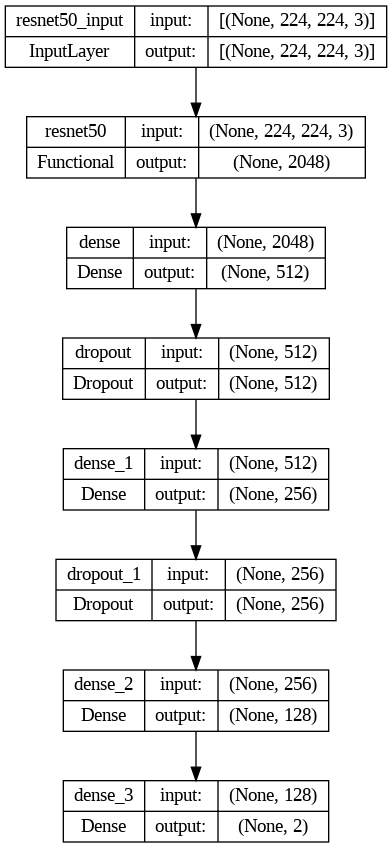

In [21]:
keras.utils.plot_model(model, "model.png", show_shapes=True)

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 2)                 2

In [23]:
model.compile(optimizer=Adam(learning_rate=0.0005),loss='sparse_categorical_crossentropy',metrics=['accuracy'])
# class_weight = {0:4, 1:1}
history = model.fit(x=train_ds,validation_data=val_ds, epochs=epochs)

Epoch 1/15
616/616 [==============================] - 1279s 2s/step - loss: 0.5822 - accuracy: 0.6894 - val_loss: 0.6383 - val_accuracy: 0.5072
Epoch 2/15
616/616 [==============================] - 75s 121ms/step - loss: 0.4769 - accuracy: 0.7473 - val_loss: 0.5265 - val_accuracy: 0.6621
Epoch 3/15
616/616 [==============================] - 75s 121ms/step - loss: 0.5112 - accuracy: 0.7321 - val_loss: 0.5685 - val_accuracy: 0.6642
Epoch 4/15
616/616 [==============================] - 75s 121ms/step - loss: 0.4508 - accuracy: 0.7692 - val_loss: 0.4944 - val_accuracy: 0.7229
Epoch 5/15
616/616 [==============================] - 75s 121ms/step - loss: 0.4349 - accuracy: 0.7754 - val_loss: 0.4428 - val_accuracy: 0.7564
Epoch 6/15
616/616 [==============================] - 75s 121ms/step - loss: 0.4073 - accuracy: 0.7980 - val_loss: 0.5567 - val_accuracy: 0.6160
Epoch 7/15
616/616 [==============================] - 75s 121ms/step - loss: 0.3410 - accuracy: 0.8430 - val_loss: 0.3223 - val_acc

In [24]:
model.evaluate(test_ds)

132/132 [==============================] - 5s 37ms/step - loss: 0.3188 - accuracy: 0.8852


[0.3188362121582031, 0.8851799368858337]

In [17]:
# !find /content/drive/MyDrive/remission/stills/normal_dataset/ -size  0 -print -delete

/content/drive/MyDrive/remission/stills/normal_dataset/1/movie4__frame28.jpg


In [25]:
model.save("/content/drive/MyDrive/remission/models/resnet_stills_finetuned_224.keras")
# model = keras.models.load_model("/content/drive/MyDrive/remission/models/resnet_stills_finetuned_224.keras")

In [45]:
import cv2
import numpy as np
from keras.models import load_model
import os

# Load your pre-trained model
# model = load_model('/content/drive/MyDrive/remission/models/resnet_stills_finetuned_224.keras')

# Function to preprocess frames
def preprocess_frame(frame, new_width=500, new_height=500):
    # Assuming your model expects 224x224 RGB images
    # frame = cv2.cropcrop(frame, (224, 224))
    height, width, _ = frame.shape
    startx = width//2 - new_width//2
    starty = height//2 - new_height//2
    return frame[starty:starty+new_height, startx:startx+new_width]
    # frame = frame / 255.0  # Normalizing
    # return frame

In [65]:
# list rem and normal videos
video_root = '/content/drive/MyDrive/remission/data_5fps/'
rem_video_paths = os.listdir('/content/drive/MyDrive/remission/data_short/val/rem')
norm_video_paths = os.listdir('/content/drive/MyDrive/remission/data_short/val/not')
video_paths = rem_video_paths + norm_video_paths

In [66]:
video_paths

['cQkl8Q33.mp4',
 'LRFgtA33.mp4',
 'oUuxWg33.mp4',
 'ZrOcuQ33.mp4',
 'AH50wg33.mp4',
 'atFUKQ33.mp4',
 'BrKlpg33.mp4',
 'fhysiQ33.mp4',
 'J1J2NA33.mp4',
 'JZPysg33.mp4',
 'mnqMRg33.mp4',
 'MOMsZg33.mp4',
 'oTgTTQ33.mp4',
 'qU7MqA33.mp4',
 'uH37DA33.mp4']

In [ ]:
from collections import Counter
rem_frames = {}
for i, path in enumerate(video_paths):
  video_path = video_root + path
  cap = cv2.VideoCapture(video_path)
  # print(cap.isOpened())
  predictions = Counter()
  probs = np.array([])
  rem_frames[path] = []
  frame_num=0

  print(f'frames in {path} video: {cap.get(cv2.CAP_PROP_FRAME_COUNT)}')
  while cap.isOpened():
      ret, frame = cap.read()
      if not ret:
          break

      # Preprocess the frame
      processed_frame = preprocess_frame(frame)

      # Predict the frame - assuming binary classification
      prediction = model.predict(np.expand_dims(processed_frame, axis=0), verbose=0)
      probs = np.append(probs, prediction)
      predictions.update(str(np.argmax(prediction)))
      # print(f'{prediction=}')
      # Handle the prediction result
      # For example, print it
      # print("Prediction: ", prediction[0])
      frame_num+=1
      if prediction[0][1] > 0.5:
        rem_frames[path].append(frame_num)
  cap.release()

  if i<4:
    print('video is rem')
  else:
    print('video is normal')

  print(f'probability mean to be normal: {probs[1::2].mean()}')
  print(f'probability mean to be rem: {probs[::2].mean()}')
  print(f'{predictions=}')
  print(f'{rem_frames[path]=}\n\n')

frames in cQkl8Q33.mp4 video: 7447.0
video is rem
probability mean to be normal: 0.9531509462887566
probability mean to be rem: 0.04684905408867473
predictions=Counter({'1': 7388, '0': 59})
rem_frames[path]=[4, 5, 6, 7, 9, 11, 12, 13, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 

In [63]:
prediction[0][1]

0.9587043

In [47]:
print(f'{probs[1::2].mean()=}')
print(f'{predictions=}')

probs[1::2].mean()=0.9258042987424858
predictions=Counter({'1': 1460, '0': 37})


In [30]:
np.argmax(prediction)

1

In [1]:
!ls /content/drive/MyDrive/remission/data_short_5fps/

1p9T5Q33.mp4  CFu40w33.mp4  J1J2NA33.mp4  MOMsZg33.mp4	QBjw0Q33.mp4  T5YjRQ33.mp4  vgkgcg33.mp4
2VCHWw33.mp4  cQkl8Q33.mp4  JZPysg33.mp4  NtibCw33.mp4	QBKPZQ33.mp4  Tai84Q33.mp4  X03DjQ33.mp4
2vqQcQ33.mp4  DF4XuA33.mp4  K3qiNg33.mp4  O8RWXA33.mp4	qRGCjw33.mp4  tgUR0A33.mp4  xV7vgQ33.mp4
55LOVQ33.mp4  e53djA33.mp4  Ksr6VQ33.mp4  odh04Q33.mp4	QT0DqA33.mp4  Tpe9eQ33.mp4  ycc8KQ33.mp4
8pk0jg33.mp4  edooAg33.mp4  LelSig33.mp4  Oqmwiw33.mp4	qU7MqA33.mp4  Tr0vnw33.mp4  ZBVlbA33.mp4
AH50wg33.mp4  fhysiQ33.mp4  lI9aLQ33.mp4  ORTdgw33.mp4	rkHIvw33.mp4  uDs6nw33.mp4  ZrOcuQ33.mp4
atFUKQ33.mp4  FOpNkA33.mp4  lQ1PgA33.mp4  oTgTTQ33.mp4	Rt8mUQ33.mp4  ug9aWQ33.mp4  zS0QPQ33.mp4
BrKlpg33.mp4  gDp5vQ33.mp4  LRFgtA33.mp4  oUuxWg33.mp4	sMgBcg33.mp4  uH37DA33.mp4
c3z64w33.mp4  HIun8w33.mp4  mnqMRg33.mp4  Pzm2oA33.mp4	svTAKA33.mp4  V3VOzw33.mp4


In [14]:
# images = np.concatenate([x for x, y in test_ds], axis=0)
labels = np.concatenate([y for x, y in test_ds], axis=0)
labels

array([1, 1, 1, ..., 1, 1, 1], dtype=int32)

In [19]:
dataset = tf.data.Dataset.from_tensor_slices(([images], [labels]))
dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(3104, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(3104,), dtype=tf.int32, name=None))>

In [11]:
predictions = model.predict(test_ds)

132/132 [==============================] - 5s 35ms/step


In [12]:
classifications = np.argmax(predictions, axis=1)

In [23]:
d = {key:[] for key in labels}
d

{3: []}

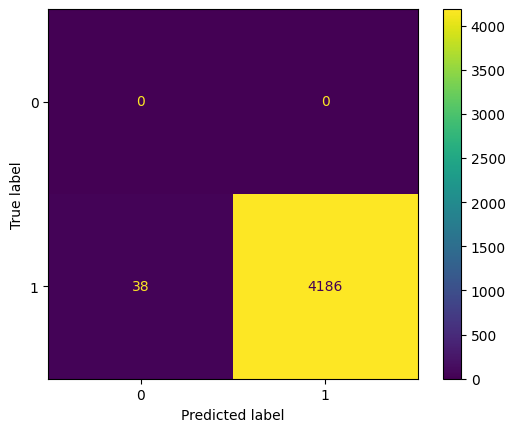

In [15]:
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay, classification_report

cm = confusion_matrix(labels, classifications)
disp = ConfusionMatrixDisplay(cm, display_labels=["0", "1"])
disp.plot()
plt.show()

In [15]:
accuracy_score(labels, classifications)

0.8394666666666667

In [8]:
model_plain = Sequential()

pretrained_model = tf.keras.applications.ResNet50(
                  include_top=False,
                  weights=None,
                  input_shape=(image_size[0],image_size[1],3),
                  pooling='avg',
                  classes=2)

# for layer in pretrained_model.layers:
#   layer.trainable=False

model_plain.add(pretrained_model)

model_plain.add(Flatten())
## Get features from the tsne and then add more layers

model_plain.add(Dense(512, activation='relu'))
model_plain.add(Dropout(0.4))
model_plain.add(Dense(256, activation='relu'))
model_plain.add(Dropout(0.3))
model_plain.add(Dense(128, activation='relu'))
model_plain.add(Dense(4, activation='softmax'))

In [9]:
model_plain.compile(optimizer=Adam(learning_rate=0.0005),loss='sparse_categorical_crossentropy',metrics=['accuracy'])
# class_weight = {0:4, 1:1}
history = model_plain.fit(x=train_ds,validation_data=val_ds, epochs=10)

Epoch 1/10
903/903 [==============================] - 4039s 4s/step - loss: 1.0072 - accuracy: 0.5945 - val_loss: 0.9415 - val_accuracy: 0.6144
Epoch 2/10
903/903 [==============================] - 283s 312ms/step - loss: 0.9073 - accuracy: 0.6175 - val_loss: 1.7121 - val_accuracy: 0.6015
Epoch 3/10
903/903 [==============================] - 268s 297ms/step - loss: 0.8184 - accuracy: 0.6591 - val_loss: 0.7781 - val_accuracy: 0.6973
Epoch 4/10
903/903 [==============================] - 283s 313ms/step - loss: 0.7276 - accuracy: 0.7002 - val_loss: 0.6339 - val_accuracy: 0.7357
Epoch 5/10
903/903 [==============================] - 285s 315ms/step - loss: 0.6276 - accuracy: 0.7446 - val_loss: 0.7196 - val_accuracy: 0.7218
Epoch 6/10
903/903 [==============================] - 268s 297ms/step - loss: 0.5697 - accuracy: 0.7692 - val_loss: 0.6740 - val_accuracy: 0.7393
Epoch 7/10
903/903 [==============================] - 270s 299ms/step - loss: 0.5144 - accuracy: 0.7955 - val_loss: 1.0215 - v

In [25]:
accuracy_score(labels, classifications)

0.9773316062176166

In [24]:
model_plain.evaluate(test_ds)

193/193 [==============================] - 19s 97ms/step - loss: 0.0837 - accuracy: 0.9773


[0.08368861675262451, 0.9773315787315369]